In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample
import joblib
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 200)


In [35]:
df = pd.read_csv("C:/89/water_potability.csv")
print("Shape (rows,cols):", df.shape)
display(df.head())
print("\nInfo:")
print(df.info())
print("\nMissing values per column:")
print(df.isna().sum())
print("\nTarget distribution (Potability):")
print(df['Potability'].value_counts())


Shape (rows,cols): (3276, 10)


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB
None

Missing values per column:
ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

Targe

In [36]:
target = 'Potability'
X = df.drop(columns=[target]).copy()
y = df[target].copy()

for c in list(X.columns):
    if df[c].isna().sum() > 0:
        X[c + "_was_missing"] = df[c].isna().astype(int)

print("Feature shape after optional missing flags:", X.shape)


Feature shape after optional missing flags: (3276, 12)


In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train target counts before upsampling:\n", y_train.value_counts())


train_combined = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
majority = train_combined[train_combined[target] == 0]
minority = train_combined[train_combined[target] == 1]

if len(minority) == 0 or len(majority) == 0:
    print("Warning: one class missing in train split — skipping upsampling.")
    X_train_bal = X_train.copy().reset_index(drop=True)
    y_train_bal = y_train.copy().reset_index(drop=True)
else:
    minority_upsampled = resample(minority,
                                  replace=True,
                                  n_samples=len(majority),
                                  random_state=42)
    train_bal = pd.concat([majority, minority_upsampled]).sample(frac=1, random_state=42).reset_index(drop=True)
    X_train_bal = train_bal.drop(columns=[target])
    y_train_bal = train_bal[target]
    print("Train target counts after upsampling:\n", y_train_bal.value_counts())


Train shape: (2457, 12) Test shape: (819, 12)
Train target counts before upsampling:
 Potability
0    1499
1     958
Name: count, dtype: int64
Train target counts after upsampling:
 Potability
0    1499
1    1499
Name: count, dtype: int64


In [38]:
impute_source = X_train_bal if 'X_train_bal' in globals() else X_train

imputer = SimpleImputer(strategy='mean')
imputer.fit(impute_source)

X_train_imputed = pd.DataFrame(imputer.transform(impute_source), columns=impute_source.columns, index=impute_source.index)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)


print("NaNs after imputation in train:", X_train_imputed.isna().sum().sum())
print("NaNs after imputation in test:", X_test_imputed.isna().sum().sum())


selector_all = SelectKBest(score_func=f_classif, k='all')
selector_all.fit(X_train_imputed, y_train_bal)

scores = pd.Series(selector_all.scores_, index=X_train_imputed.columns).sort_values(ascending=False)
display(scores.head(30))


K = 8
selector = SelectKBest(score_func=f_classif, k=K)
selector.fit(X_train_imputed, y_train_bal)

mask = selector.get_support()
selected_features = X_train_imputed.columns[mask].tolist()
print("Top", K, "selected features:", selected_features)

X_train_sel = pd.DataFrame(selector.transform(X_train_imputed), columns=selected_features, index=X_train_imputed.index)
X_test_sel = pd.DataFrame(selector.transform(X_test_imputed), columns=selected_features, index=X_test_imputed.index)
print("Shapes after selection:", X_train_sel.shape, X_test_sel.shape)


NaNs after imputation in train: 0
NaNs after imputation in test: 0


Trihalomethanes_was_missing    6.663503
Solids                         4.702941
Sulfate_was_missing            1.897131
Turbidity                      0.924127
Sulfate                        0.433170
ph                             0.400999
Organic_carbon                 0.313447
Trihalomethanes                0.251566
ph_was_missing                 0.164834
Hardness                       0.140906
Conductivity                   0.015786
Chloramines                    0.009912
dtype: float64

Top 8 selected features: ['ph', 'Solids', 'Sulfate', 'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Sulfate_was_missing', 'Trihalomethanes_was_missing']
Shapes after selection: (2998, 8) (819, 8)


Baseline RF accuracy: 0.6263736263736264
              precision    recall  f1-score   support

           0       0.64      0.86      0.74       499
           1       0.55      0.26      0.35       320

    accuracy                           0.63       819
   macro avg       0.60      0.56      0.54       819
weighted avg       0.61      0.63      0.59       819



ph                             0.178443
Solids                         0.166743
Sulfate                        0.166171
Turbidity                      0.159062
Organic_carbon                 0.156664
Trihalomethanes                0.152442
Sulfate_was_missing            0.013059
Trihalomethanes_was_missing    0.007416
dtype: float64

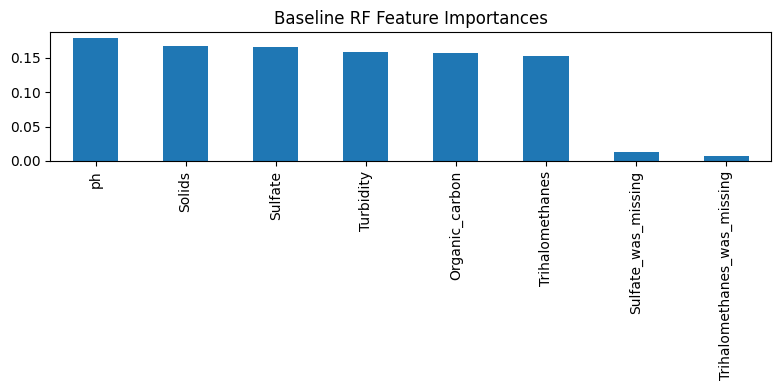

In [39]:

rf_base = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
rf_base.fit(X_train_sel, y_train_bal)
y_pred_base = rf_base.predict(X_test_sel)
print("Baseline RF accuracy:", accuracy_score(y_test, y_pred_base))
print(classification_report(y_test, y_pred_base))


feat_imp = pd.Series(rf_base.feature_importances_, index=X_train_sel.columns).sort_values(ascending=False)
display(feat_imp)
plt.figure(figsize=(8,4))
feat_imp.plot(kind='bar')
plt.title('Baseline RF Feature Importances')
plt.tight_layout()
plt.show()


In [40]:

pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),  
    ('rf', RandomForestClassifier(random_state=42))
])

param_dist = {
    'rf__n_estimators': [100, 200, 300, 500],
    'rf__max_depth': [5, 10, 15, 20, None],
    'rf__min_samples_split': [2, 4, 6],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['sqrt', 'log2', None],
    'rf__class_weight': [None, 'balanced']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search_rf = RandomizedSearchCV(pipeline_rf, param_distributions=param_dist,
                               n_iter=25, scoring='accuracy', cv=cv, random_state=42, n_jobs=-1, verbose=1)
search_rf.fit(X_train_sel, y_train_bal)

print("Best RF params:", search_rf.best_params_)
best_rf = search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test_sel)
print("Tuned RF accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best RF params: {'rf__n_estimators': 200, 'rf__min_samples_split': 6, 'rf__min_samples_leaf': 1, 'rf__max_features': 'sqrt', 'rf__max_depth': 20, 'rf__class_weight': None}
Tuned RF accuracy: 0.6288156288156288
              precision    recall  f1-score   support

           0       0.65      0.85      0.74       499
           1       0.55      0.29      0.38       320

    accuracy                           0.63       819
   macro avg       0.60      0.57      0.56       819
weighted avg       0.61      0.63      0.60       819



In [41]:
pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=False, random_state=42))
])

param_dist_svm = {
    'svm__C': [0.1, 1, 2, 5, 10],
    'svm__gamma': ['scale', 0.01, 0.1, 1],
    'svm__kernel': ['rbf']   # add 'linear' if you want to try
}

search_svm = RandomizedSearchCV(pipeline_svm, param_distributions=param_dist_svm,
                               n_iter=12, scoring='accuracy', cv=cv, random_state=42, n_jobs=-1, verbose=1)
search_svm.fit(X_train_sel, y_train_bal)

print("Best SVM params:", search_svm.best_params_)
best_svm = search_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test_sel)
print("Tuned SVM accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best SVM params: {'svm__kernel': 'rbf', 'svm__gamma': 1, 'svm__C': 5}
Tuned SVM accuracy: 0.5982905982905983
              precision    recall  f1-score   support

           0       0.64      0.77      0.70       499
           1       0.48      0.34      0.40       320

    accuracy                           0.60       819
   macro avg       0.56      0.55      0.55       819
weighted avg       0.58      0.60      0.58       819



In [42]:
acc_rf = accuracy_score(y_test, best_rf.predict(X_test_sel))
acc_svm = accuracy_score(y_test, best_svm.predict(X_test_sel))

results = pd.DataFrame({
    'model': ['RandomForest (tuned)', 'SVM (tuned)'],
    'accuracy': [acc_rf, acc_svm]
}).sort_values(by='accuracy', ascending=False).reset_index(drop=True)

display(results)

if acc_rf >= acc_svm:
    chosen_name = 'rf'
    chosen_model = best_rf
    chosen_acc = acc_rf
else:
    chosen_name = 'svm'
    chosen_model = best_svm
    chosen_acc = acc_svm

print(f"Chosen best model: {chosen_name} with accuracy {chosen_acc:.4f}")

# Save model package: model, imputer, selector, selected_features
joblib.dump({
    'model': chosen_model,
    'imputer': imputer,
    'selector': selector,
    'selected_features': selected_features
}, f"./best_water_model_{chosen_name}.pkl")

print("Saved model package to:", f"./best_water_model_{chosen_name}.pkl")


,model,accuracy
0,RandomForest (tuned),0.628816
1,SVM (tuned),0.598291


Chosen best model: rf with accuracy 0.6288
Saved model package to: ./best_water_model_rf.pkl


Final Accuracy: 0.6288156288156288
              precision    recall  f1-score   support

           0       0.65      0.85      0.74       499
           1       0.55      0.29      0.38       320

    accuracy                           0.63       819
   macro avg       0.60      0.57      0.56       819
weighted avg       0.61      0.63      0.60       819



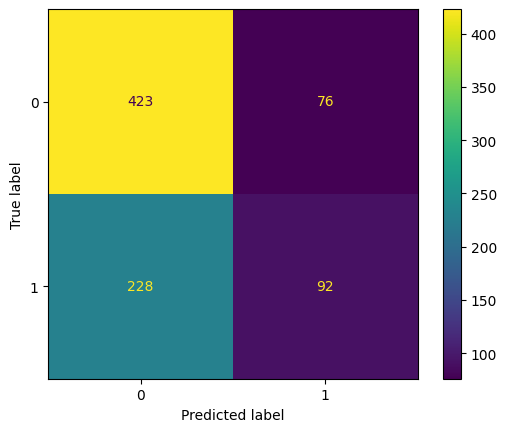

Sulfate                        0.182207
ph                             0.179532
Solids                         0.165298
Organic_carbon                 0.154510
Turbidity                      0.151105
Trihalomethanes                0.146038
Sulfate_was_missing            0.012899
Trihalomethanes_was_missing    0.008410
dtype: float64

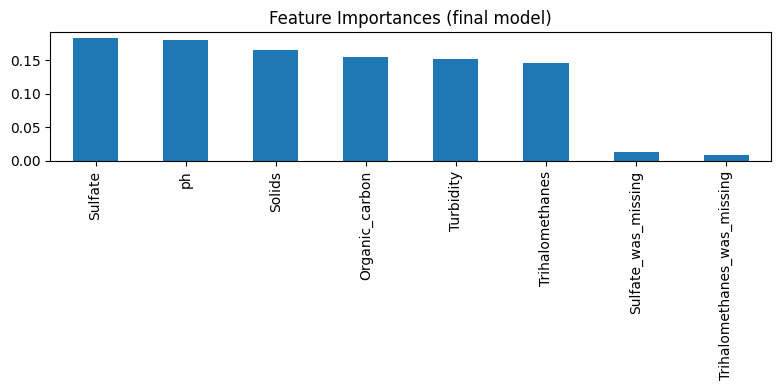

In [43]:
from sklearn.metrics import ConfusionMatrixDisplay

pkg = joblib.load(f"./best_water_model_{chosen_name}.pkl")
model_for_infer = pkg['model']
selector_for_infer = pkg['selector']
imputer_for_infer = pkg['imputer']
selected_features_for_infer = pkg['selected_features']


X_test_imputed_local = pd.DataFrame(imputer_for_infer.transform(X_test), columns=X_test.columns, index=X_test.index)
X_test_selected_local = pd.DataFrame(selector_for_infer.transform(X_test_imputed_local), columns=selected_features_for_infer, index=X_test.index)

y_final_pred = model_for_infer.predict(X_test_selected_local)
print("Final Accuracy:", accuracy_score(y_test, y_final_pred))
print(classification_report(y_test, y_final_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_final_pred)
plt.show()


if hasattr(model_for_infer.named_steps.get('rf', model_for_infer), 'feature_importances_'):
    rf_obj = model_for_infer.named_steps['rf'] if 'rf' in getattr(model_for_infer, 'named_steps', {}) else model_for_infer
    importances = pd.Series(rf_obj.feature_importances_, index=selected_features_for_infer).sort_values(ascending=False)
    display(importances)
    plt.figure(figsize=(8,4))
    importances.plot(kind='bar')
    plt.title('Feature Importances (final model)')
    plt.tight_layout()
    plt.show()
